### Part 5: Machine Learning

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
X_ = pd.read_csv('data/features.csv', parse_dates = [1], index_col = [0, 1])
y_ = pd.read_csv('data/target.csv', parse_dates = [1], index_col = [0, 1])

In [3]:
X = X_.reset_index().sort_values(by='Date').reset_index(drop=True).set_index(['Date', 'StartStation Id'])
y = y_.reset_index().sort_values(by='Date').reset_index(drop=True).set_index(['Date', 'StartStation Id'])

In [46]:
from sklearn.model_selection import train_test_split

train_dates, test_dates = train_test_split(X.index.get_level_values(0).unique(), shuffle=False, test_size=0.3)
X_train, y_train = X.loc[train_dates], y.loc[train_dates]
X_test, y_test = X.loc[test_dates], y.loc[test_dates]

#### Benchmark Model

In [52]:
class BenchmarkModel:
    def __init__(self):
        self.y_pred = None
    
    def predict(self, X_test):
        self.y_pred = X_test['start_count_day_bf']
        return self.y_pred
    
    def score(self, X_test, y_test, scoring_func, plot_residuals=False):
        # MAPE-mean absolute percentage error
        if self.y_pred == None:
            self.y_pred = BenchmarkModel.predict(self, X_test)
        
        if plot_residuals == True:
            residuals = y_test.values.reshape(-1) - self.y_pred.values
            plt.plot(np.arange(len(y_test)), residuals, 'o', label='Residuals')
            plt.plot(np.arange(len(y_test)), np.zeros(len(y_test)), '--')
            plt.legend()
            plt.show()

        return scoring_func(y_test.values.reshape(-1), self.y_pred.values)

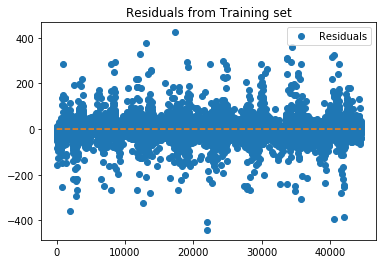

589.1301974526585

In [112]:
model = BenchmarkModel()
plt.title('Residuals from Training set')
model.score(X_train, y_train, mean_squared_error, plot_residuals=True)

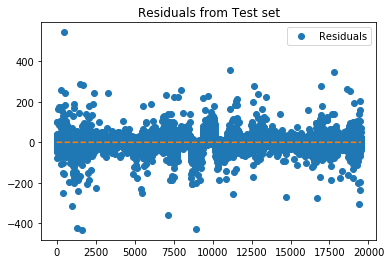

710.3220486555698

In [48]:
model = BenchmarkModel()
plt.title('Residuals from Test set')
model.score(X_test, y_test, mean_squared_error, plot_residuals=True)

#### Linear Regression

In [82]:
def score(y_test, y_pred, scoring_func, plot_residuals=False):
    
    if plot_residuals == True:
            residuals = y_test - y_pred
            plt.plot(np.arange(len(y_test)), residuals, 'o', label='Residuals')
            plt.plot(np.arange(len(y_test)), np.zeros(len(y_test)), '--')
            plt.legend()
            plt.show()

    return scoring_func(y_test, y_pred)

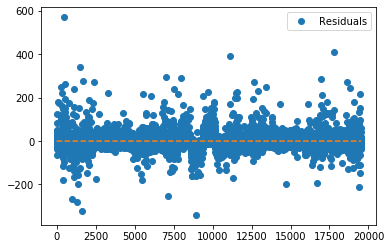

594.6061002119249

In [145]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
score(y_test, reg.predict(X_test), mean_squared_error, plot_residuals=True)

In [117]:
# coefficients
pd.DataFrame(reg.coef_, columns=X_test.columns)

,day_no,is_weekday,start_count_day_bf,end_count_day_bf,7d_rolling_dur,temperature,wind_speed,good_weather,ok_weather,bad_weather,very_bad_weather
0,-1.872117,-1.715196,0.391091,0.397864,0.086893,-0.381733,-0.043915,-7.397081,-10.576342,-48.983594,66.957017


#### Ridge Regression

In [240]:
from sklearn.linear_model import Ridge

errs = []
for alpha_val in [0.01, 0.1, 1, 10, 100, 500]:
    mse_err = 0
    for train_index, test_index in TimeSeriesSplit(n_splits=5).split(X_train):
        reg = Ridge(alpha=alpha_val).fit(X_train.iloc[train_index], y_train.iloc[train_index])
        mse_err += score(y_train.iloc[test_index], reg.predict(X_train.iloc[test_index]), mean_squared_error)
    errs.append(mse_err/5)

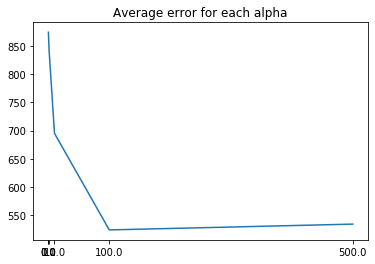

In [245]:
plt.plot([0.01, 0.1, 1, 10, 100, 500], errs)
plt.xticks([0.01, 0.1, 1, 10, 100, 500])
plt.title('Average error for each alpha')
plt.show()

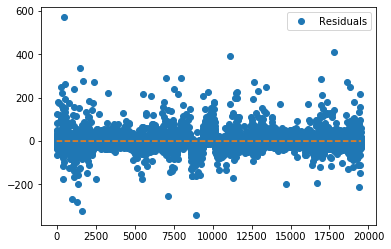

595.3357311594947

In [140]:
reg = Ridge(alpha=100).fit(X_train, y_train)
score(y_test, reg.predict(X_test), mean_squared_error, plot_residuals=True)

In [142]:
# coefficients
pd.DataFrame(reg.coef_, columns=X_test.columns)

,day_no,is_weekday,start_count_day_bf,end_count_day_bf,7d_rolling_dur,temperature,wind_speed,good_weather,ok_weather,bad_weather,very_bad_weather
0,-1.919687,-2.041009,0.391305,0.397867,0.086086,-0.248659,-0.030572,11.6433,7.440203,-21.759177,2.675674


#### Gradient boosting

In [246]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(loss='ls', n_estimators=250, max_depth=5, learning_rate=0.01, 
                                       min_samples_leaf=10, min_samples_split=10)
gb_reg.fit(X_train, y_train.values.reshape(-1))
print(score(y_test.values.reshape(-1), gb_reg.predict(X_test), mean_squared_error))

553.1615241503856


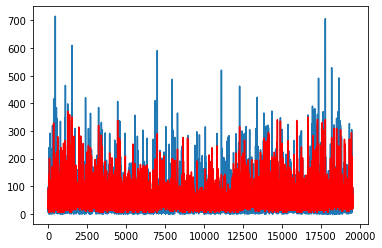

In [247]:
plt.plot(y_test.values)
plt.plot(gb_reg.predict(X_test), color='r')

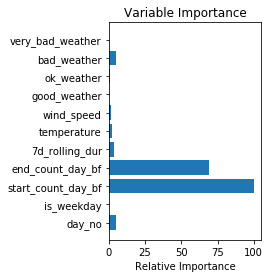

In [181]:
feature_importance = gb_reg.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance, align='center')
plt.yticks(pos, X_train.columns)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [177]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [225]:
reg = xgb.XGBRegressor(n_estimators=1000, max_depth=1, learning_rate=0.05, objective='reg:squarederror')
reg.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [226]:
score(y_train, reg.predict(X_train), mean_squared_error)

445.4473209985299

In [227]:
score(y_test, reg.predict(X_test), mean_squared_error)

612.1712521851049

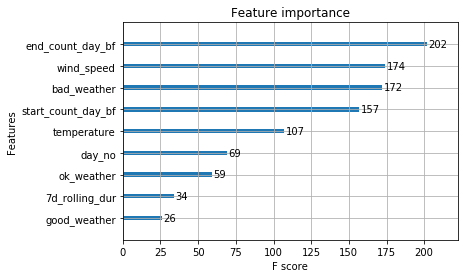

In [228]:
_ = plot_importance(reg)

#### Leverage points

In [249]:
import statsmodels.api as sm

In [251]:
results = sm.OLS(y_train, X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     8721.
Date:                Tue, 07 Jan 2020   Prob (F-statistic):               0.00
Time:                        15:30:15   Log-Likelihood:            -2.0094e+05
No. Observations:               44517   AIC:                         4.019e+05
Df Residuals:                   44506   BIC:                         4.020e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
day_no                -1.8721      0

In [259]:
import statsmodels 

influence = statsmodels.stats.outliers_influence.OLSInfluence(results)
lev = influence.hat_matrix_diag
high_lev = np.where(lev > (np.mean(lev) + 5*np.std(lev)))[0]

print('High leverage points are at row numbers: {}'.format(high_lev))

High leverage points are at row numbers: [  252   294   828  1964  2000  2663  2894  3492  4248  4349  4729  4844
  5235  5291  5432  6070  6461  6794  7142  7180  7991  7997  8623  8736
  8803  9473  9638  9804  9916  9929 10534 10694 10958 11264 11564 11602
 11754 11816 12084 12537 12668 12769 12941 13224 13446 13554 13719 13827
 14083 14127 14187 14379 14395 14399 14436 14461 14470 14482 14629 14637
 15011 15547 16419 16420 16970 17041 17116 17228 17428 17456 17574 17896
 18156 18205 18213 18250 18326 18564 18698 18746 19085 19203 19314 19967
 19997 19998 20089 20139 20154 20457 20693 20718 20784 20805 20872 20961
 21205 21215 21479 21499 21791 21801 21885 22002 22037 22104 22266 22454
 22495 22544 22917 23397 23734 23795 24204 24254 25530 25725 25869 26267
 26507 27969 27996 28073 28080 28685 29389 29481 29516 29713 30837 31628
 31659 31863 32169 32183 32260 32316 32423 32575 33377 33913 34725 34851
 34914 35070 35472 35730 35734 35904 35947 36174 36421 36707 36887 36964
 37046 374

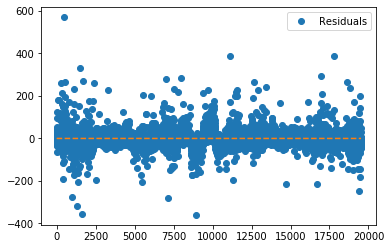

629.1257682459002

In [262]:
reg = LinearRegression().fit(X_train.iloc[~high_lev], y_train.iloc[~high_lev])
score(y_test, reg.predict(X_test), mean_squared_error, plot_residuals=True)

In [263]:
residuals = y_test - reg.predict(X_test)

In [285]:
val = (np.mean(residuals) + 5*np.std(residuals)).values[0]
idx = residuals.index[residuals['count'] > val].tolist()

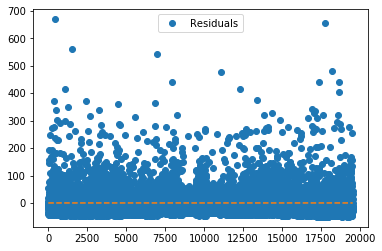

1515.3401850109492

In [314]:
r = LinearRegression().fit(X_train[cols], y_train)
score(y_test, r.predict(X_test[cols]), mean_squared_error, plot_residuals=True)